The Kentucky Derby is on Saturday, and a field of 20 horses is slated to run “the fastest two minutes in sports” in pursuit of the right to be draped with a blanket of roses. But let’s consider, instead, the Lucky Derby, where things are a little more bizarre:

The bugle sounds, and 20 horses make their way to the starting gate for the first annual Lucky Derby. These horses, all trained at the mysterious Riddler Stables, are special. Each second, every Riddler-trained horse takes one step. Each step is exactly one meter long. But what these horses exhibit in precision, they lack in sense of direction. Most of the time, their steps are forward (toward the finish line) but the rest of the time they are backward (away from the finish line). As an avid fan of the Lucky Derby, you’ve done exhaustive research on these 20 competitors. You know that Horse One goes forward 52 percent of the time, Horse Two 54 percent of the time, Horse Three 56 percent, and so on, up to the favorite filly, Horse Twenty, who steps forward 90 percent of the time. The horses’ steps are taken independently of one another, and the finish line is 200 meters from the starting gate.

Handicap this race and place your bets! In other words, what are the odds (a percentage is fine) that each horse wins?

Extra credit: Animate this derby. I’ll broadcast the highlights next week.

In [1]:
import random
from matplotlib import pyplot as plt
from matplotlib import rc, animation
from matplotlib.ticker import FuncFormatter, MultipleLocator
import matplotlib.cm as cm
import itertools
from IPython.display import HTML
import numpy as np
from scipy.stats import mvn, binom

rc('animation', html='html5')

In [2]:
def format_time(time):
    m, s = divmod(int(time), 60)
    min_text = "   "
    
    if m > 0:
        min_text = "{0:>2d}m".format(m)
        
    return "{0} {1:>2d}s".format(min_text,s)

In [3]:
class Horse:
    step = 1
    
    def __init__(self, forward_prob):
        self.forward_prob = forward_prob
        self.position = 0
        self.finished = False
        
    def take_step(self, race_distance):
        if not self.finished:
            if random.random() < self.forward_prob:
                self.position += self.step
                if self.position >= race_distance:
                    self.position = race_distance
                    self.finished = True
            else:
                self.position -= self.step
        
        return self.position

In [4]:
class Race:
    
    def __init__(self, horse_forward_probs, distance):
        self.distance = distance
        self.horses = [Horse(forward_prob) for forward_prob in horse_forward_probs]
        
    def run_race(self):
        self.results = [[0 for _ in self.horses]]
        while not all([h.finished for h in self.horses]):
            self.results.append([h.take_step(self.distance) for h in self.horses])
        
    def results_by_time(self):
        return self.results
        
    def results_by_horse(self):
        return list(zip(*self.results))
        
    def race_time(self):
        return len(self.results)

    def num_horses(self):
        return len(self.horses)
    
    def horse_probabilities(self):
        return [h.forward_prob for h in self.horses]
    
    def horse_indices(self):
        return list(range(self.num_horses()))

In [5]:
HORSE_FORWARD_PROBS = [.5 + .02*i for i in range(1, 21)]
DISTANCE = 200

derby = Race(HORSE_FORWARD_PROBS,DISTANCE)
derby.run_race()

CMAP = cm.rainbow(np.linspace(0, 1, derby.num_horses()))

In [6]:
def plot_positions(race, cmap):
    fig, ax = plt.subplots(figsize=(12, 8))
        
    for i, h in enumerate(race.results_by_horse()):
        ax.plot(h, color=cmap[i], linewidth=1)

    ymin,ymax = ax.get_ylim()
    ax.set_ylim(ymin, race.distance)
    ax.set_xlim(0, race.race_time())

    ax.xaxis.set_major_locator(MultipleLocator(600))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: int(x/60)))
    
    ax.set_title("Horse Position vs. Time")
    ax.set_xlabel("Time [min]")
    ax.set_ylabel("Position [m]")
    
    plt.show()

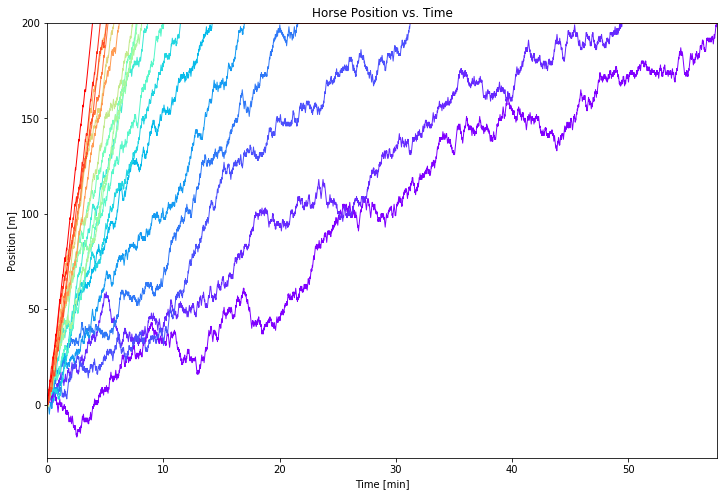

In [7]:
plot_positions(derby, CMAP)

In [8]:
def plot_finish_times(race, cmap):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.set_xlim([-0.5, race.num_horses()-0.5])
    ax.set_xticks(race.horse_indices())
    ax.xaxis.set_ticklabels(["{:<2.0f}".format(p*100) for p in race.horse_probabilities()])
    
    ax.yaxis.set_major_locator(MultipleLocator(600))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: int(x/60)))
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    ax.grid(b=True, which='major', axis='y', linestyle='--')
 
    ax.bar(race.horse_indices(),
           [h.index(race.distance) for h in race.results_by_horse()],
           color=cmap,
           edgecolor='black',
           linewidth=2,
           zorder=10)
    
    ax.set_title("Simulated Finish Time vs. Odds Horse Advances")
    ax.set_xlabel("Odds Horse Advances [%]")
    ax.set_ylabel("Finish Time [min]")
    
    plt.show()

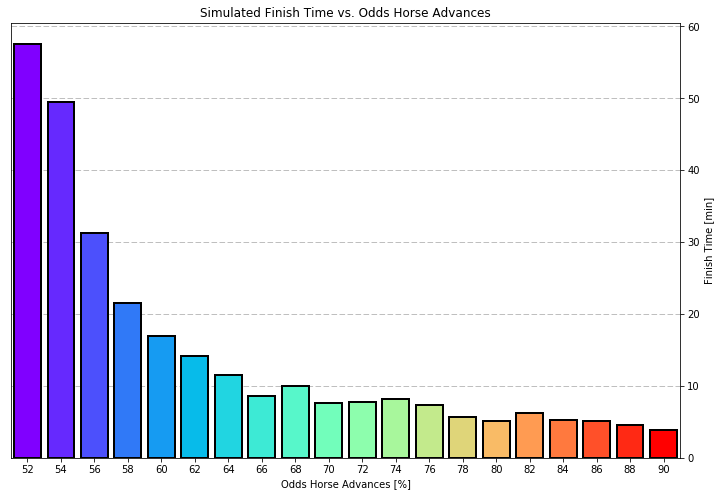

In [9]:
plot_finish_times(derby, CMAP)

In [10]:
def create_axes(race, cmap):
    xmin = min(min(r) for r in race.results)
    
    fig, ax = plt.subplots(figsize=(10, race.num_horses()/5))
    ax.axvline(color="white")
    
    overall_time = ax.text(35, race.num_horses()*(5/6), "", 
                           color="white",
                           verticalalignment='center',
                           horizontalalignment='right',
                           family='monospace',
                           size='xx-large')
    
    dots = []
    finish_times = []
    for i in race.horse_indices():
        dot = ax.plot([], 
                      [] ,
                      'o', 
                      markersize=10,
                      color=cmap[i])
        time = ax.text(race.distance-5, i+0.5, "", 
                       color="white",
                       verticalalignment='center',
                       horizontalalignment='right',
                       family='monospace',
                       size='large')
        dots.append(dot[0])
        finish_times.append(time)
    
    
    
    ax.set_facecolor('#573B0C')
    ax.set_position([0, 0, 1, 1])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off')
    ax.set_xlim([xmin, race.distance])
    ax.set_ylim([0, race.num_horses()])
    return fig, dots, finish_times, overall_time

In [11]:
def update_axes(frame_num, dots_gen, fig, dots, finish_times, overall_time, race):
    next_dot_positions = next(dots_gen)
    for i, (dot, next_pos, finish) in enumerate(zip(dots, next_dot_positions, finish_times)):
        dot.set_xdata(next_pos)
        dot.set_ydata(i+0.5)
        if next_pos >= race.distance and finish.get_text() == "":
            finish.set_text(format_time(frame_num))
    overall_time.set_text(format_time(frame_num))
    return fig, dots, finish_times, overall_time

In [12]:
def create_animation(race, cmap, frames=None, delay_frames=None):
    if delay_frames is None:
        delay_frames = 250
    
    positions = race.results + delay_frames*[race.results[-1]]
    dots_gen = itertools.cycle(positions)
    
    if frames is None:
        frames = len(positions)
        
    fig, dots, finish_times, overall_time = create_axes(race, cmap)
    line_ani = animation.FuncAnimation(fig,
                                       update_axes,
                                       frames=frames,
                                       fargs=(dots_gen,
                                              fig, dots,
                                              finish_times,
                                              overall_time,
                                              race),
                                       repeat=True,
                                       interval=50,
                                       save_count=frames)

    return line_ani

In [13]:
derby_anim = create_animation(derby, CMAP)
derby_anim.save("derby_animation.gif", writer="imagemagick", fps=24)
derby_anim

In [14]:
plt.close()

https://vtechworks.lib.vt.edu/bitstream/handle/10919/37928/LD5655.V856_1968.D4.pdf?sequence=1&isAllowed=y

> Let $x$ be the random variable representing the total amount of time required for the $i^{th}$ random walk to reach the origin independently of the other walks.

$$x = \sum_{j=1}^{A} t_j$$

> Since each $x$ is the sum of independent, identically distributed random variables, each possessing finite mean and variance, we know that the mean of $x$ will simply be the sum of means and its variance the sum of the of the $t_j$ involved.  Each $x$  will tend to be normally distributed with mean $\mu$ and variance $\sigma^2$



$$x \smallfrown N(\mu , \sigma^2)$$

Now let's create a distribution for each horse:

$$\underline{x} = \begin{bmatrix} 
x_1 \\ 
x_2 \\ 
x_3 \\ 
\vdots \\
x_n \\ 
\end{bmatrix},
\underline{\mu} = \begin{bmatrix} 
\mu_1 \\ 
\mu_2 \\ 
\mu_3 \\ 
\vdots \\
\mu_n \\ 
\end{bmatrix},
\underline{\sigma}= \begin{bmatrix} 
\sigma_1^2 & 0 & 0 & \ldots & 0 \\ 
0 & \sigma_2^2 & 0 & \ldots & 0 \\ 
\ldots & \ldots & \ldots & \ldots & \ldots \\ 
0 & 0 & 0 & \ldots & \sigma_n^2 \\ 
\end{bmatrix}$$

In [15]:
def plot_pmfs(race, cmap):
    fig, ax = plt.subplots(figsize=(12, 8))
       
    ns = range(190,450)
    
    for i, prob in enumerate(race.horse_probabilities()):
        ax.axvline(DISTANCE/prob, color='black', zorder=-100)
        ax.bar(ns,
               [binom.pmf(race.distance, n, prob) for n in ns],
               width=1,
               color=cmap[i],
               zorder=-i)
    
    plt.show()

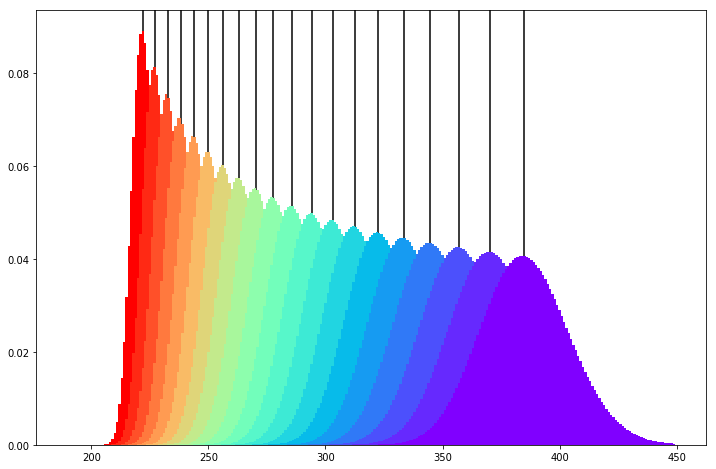

In [16]:
plot_pmfs(derby, CMAP)

$$y = \begin{bmatrix} 
y_1 \\ 
y_2 \\
\vdots \\
y_{n-1}
\end{bmatrix}
=
\begin{bmatrix} 
x_1 - x_2 \\ 
x_1 - x_3 \\ 
\vdots \\
x_1 - x_n
\end{bmatrix}$$
and
$$
T = \begin{bmatrix} 
1 & -1 & 0 & \ldots & 0 \\ 
1 & 0 & -1 & \ldots & 0 \\ 
\vdots & \vdots & \vdots & \ddots & \vdots \\ 
1 & 0 & 0 & \ldots & -1 \\ 
\end{bmatrix}
$$

$$y \smallfrown N_{n-1}(T\mu , T\Sigma T')$$

$$T\mu = \begin{bmatrix} 
\mu_1 - \mu_2 \\ 
\mu_1 - \mu_3 \\ 
\mu_1 - \mu_4 \\ 
\ldots \\
\mu_1 - \mu_n \\ 
\end{bmatrix}$$

$$T \Sigma T'= \begin{bmatrix} 
(\sigma_1^2 + \sigma_2^2) & \sigma_1^2 & \sigma_1^2 & \ldots & \sigma_1^2 \\ 
\sigma_1^2 & (\sigma_1^2 + \sigma_3^2) & \sigma_1^2 & \ldots & \sigma_1^2 \\ 
\vdots & \vdots & \vdots & \ddots & \vdots \\ 
\sigma_1^2 & \sigma_1^2 & \sigma_1^2 & \ldots & (\sigma_1^2 + \sigma_n^2) \\ 
\end{bmatrix}(n-1)\times(n-1)$$

For 3 horses only:

$$T\mu = \begin{bmatrix} 
\mu_1 - \mu_2 \\ 
\mu_1 - \mu_3 \\ 
\end{bmatrix}$$

$$T \Sigma T'= \begin{bmatrix} 
(\sigma_1^2 + \sigma_2^2) & \sigma_1^2 \\ 
\sigma_1^2 & (\sigma_1^2 + \sigma_3^2) \\ 
\end{bmatrix}$$

$$y = \begin{bmatrix} 
y_1 \\ 
y_2 \\ 
\end{bmatrix}
=
\begin{bmatrix} 
x_1 - x_2 \\ 
x_1 - x_3 \\ 
\end{bmatrix}
\leq
\begin{bmatrix} 
\frac{1}{2} \\ 
\frac{1}{2} \\ 
\end{bmatrix}
$$

This is $\leq \frac{1}{2}$ because of the possibility of ties in the discrete case

$$\mu_1 = \frac{L}{\alpha}, \sigma_1^2 = \frac{L(1-\alpha)}{\alpha^2}$$
$$\mu_2 = \frac{L}{\beta}, \sigma_2^2 = \frac{L(1-\beta)}{\beta^2}$$
$$\mu_3 = \frac{L}{\gamma}, \sigma_3^2 = \frac{L(1-\gamma)}{\gamma^2}$$

$$y_1 \smallfrown N\left[\left(\frac{L}{\alpha}-\frac{L}{\beta}\right) , \left(\frac{L(1-\alpha)}{\alpha^2} + \frac{L(1-\beta)}{\beta^2}\right)\right]$$
$$y_2 \smallfrown N\left[\left(\frac{L}{\alpha}-\frac{L}{\gamma}\right) , \left(\frac{L(1-\alpha)}{\alpha^2} + \frac{L(1-\gamma)}{\gamma^2}\right)\right]$$

In [17]:
def approximate_horse_winning(race, winner_index):
    horse_mus = [race.distance/prob for prob in race.horse_probabilities()]
    horse_vars = [(race.distance* (1-prob))/prob**2 for prob in race.horse_probabilities()]
    
    winner_mu = horse_mus[winner_index]
    winner_var = horse_vars[winner_index]
    
    del horse_mus[winner_index]
    del horse_vars[winner_index]
    
    num_loser_horses = race.num_horses() -1
    
    mus = winner_mu * np.ones(num_loser_horses)
    mus -= horse_mus
                         
    covar = winner_var * np.ones((num_loser_horses,num_loser_horses))
    covar[np.diag_indices_from(covar)] += horse_vars
                                                   
    low = -500 * np.ones(num_loser_horses)
    upp = 0.5 * np.ones(num_loser_horses)
    
    p,i = mvn.mvnun(low,upp,mus,covar)
    
    return p                               

In [18]:
for i in derby.horse_indices():
    print("{0:2d} {1:.3E}".format(i, approximate_horse_winning(derby, i)))

 0 1.149E-17
 1 1.365E-16
 2 1.546E-15
 3 1.779E-14
 4 1.941E-13
 5 2.126E-12
 6 2.276E-11
 7 2.346E-10
 8 2.329E-09
 9 2.219E-08
10 2.007E-07
11 1.707E-06
12 1.347E-05
13 9.714E-05
14 6.284E-04
15 3.565E-03
16 1.736E-02
17 7.138E-02
18 2.463E-01
19 7.190E-01


In [19]:
def plot_win_probs(race, cmap):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.set_xlim([-0.5, race.num_horses()-0.5])
    ax.set_xticks(race.horse_indices())
    ax.xaxis.set_ticklabels(["{:<2.0f}".format(p*100) for p in race.horse_probabilities()])

    ax.grid(b=True, which='major', axis='y', linestyle='--')
    
    ax.bar(race.horse_indices(),
           [approximate_horse_winning(derby, i) for i in race.horse_indices()],
           color=cmap,
           edgecolor='black',
           linewidth=2,
           zorder=10,
           log=True)
    
    ax.autoscale(enable=True, axis='y')
    
    ax.set_title("Overall Win Probability vs. Odds Horse Advances")
    ax.set_xlabel("Odds Horse Steps Forward [%]")
    ax.set_ylabel("Overall Win Probability")
    
    plt.show()

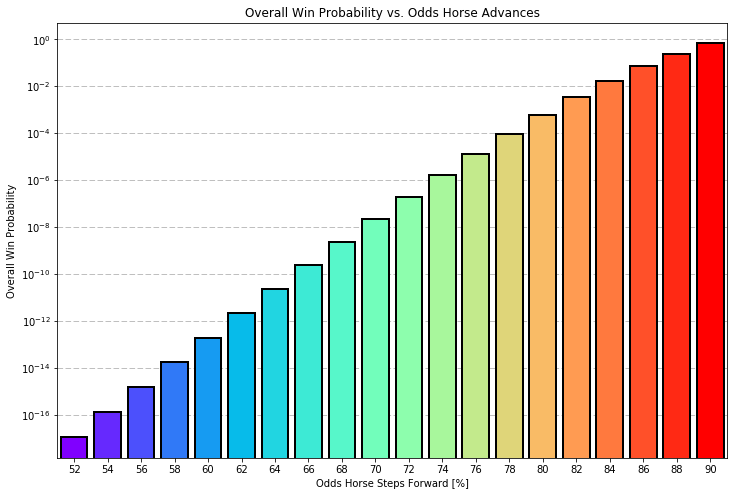

In [20]:
plot_win_probs(derby, CMAP)

In [33]:
HORSE_FORWARD_PROBS = [.5 + .01*i for i in range(1, 41)]
DISTANCE = 50

derby = Race(HORSE_FORWARD_PROBS,DISTANCE)
derby.run_race()

CMAP = cm.rainbow(np.linspace(0, 1, derby.num_horses()))

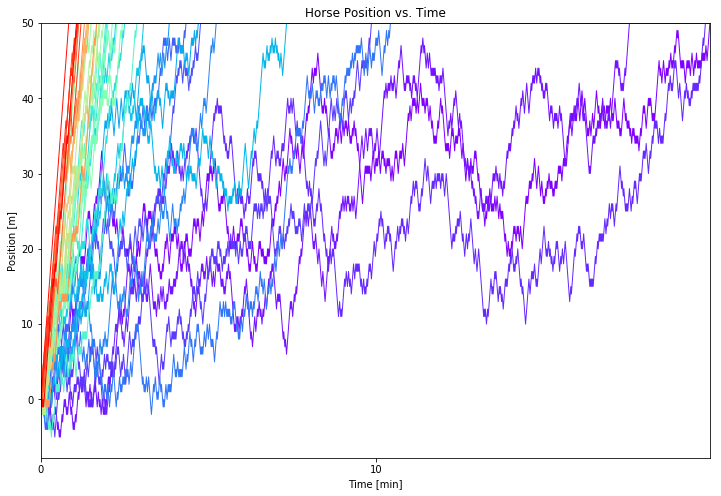

In [34]:
plot_positions(derby, CMAP)

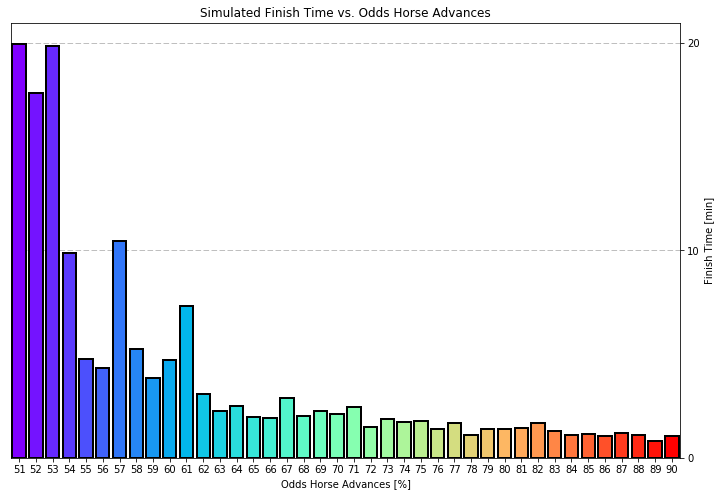

In [35]:
plot_finish_times(derby, CMAP)

In [36]:
for i in derby.horse_indices():
    print("{0:2d} {1:.3E}".format(i, approximate_horse_winning(derby, i)))

 0 2.761E-06
 1 3.600E-06
 2 5.153E-06
 3 7.143E-06
 4 1.156E-05
 5 1.215E-05
 6 2.048E-05
 7 2.460E-05
 8 4.005E-05
 9 4.098E-05
10 5.317E-05
11 8.844E-05
12 1.068E-04
13 1.804E-04
14 1.996E-04
15 2.907E-04
16 3.979E-04
17 4.966E-04
18 8.913E-04
19 1.483E-03
20 1.313E-03
21 1.798E-03
22 2.054E-03
23 2.999E-03
24 3.921E-03
25 5.628E-03
26 7.203E-03
27 1.059E-02
28 1.428E-02
29 1.699E-02
30 2.703E-02
31 3.284E-02
32 4.265E-02
33 5.467E-02
34 7.928E-02
35 1.018E-01
36 1.369E-01
37 1.927E-01
38 2.331E-01
39 3.127E-01


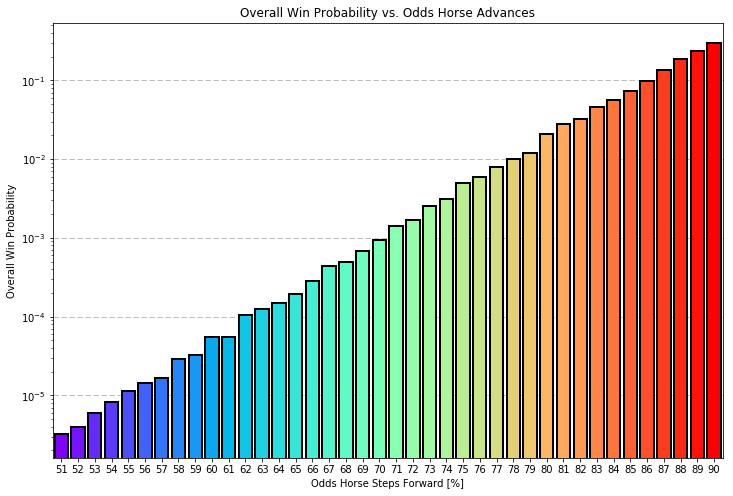

In [37]:
plot_win_probs(derby, CMAP)

In [40]:
HORSE_FORWARD_PROBS = [.8 + .02*i for i in range(1, 7)]
DISTANCE = 200

derby = Race(HORSE_FORWARD_PROBS,DISTANCE)
derby.run_race()

CMAP = cm.rainbow(np.linspace(0, 1, derby.num_horses()))

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

def horse_animation(race, cmap):
    xmin = min(min(r) for r in race.results)
    
    fig, ax = plt.subplots(figsize=(10, race.num_horses()*(1/2)))
    ax.axvline(color="white")
    ax.axvline(race.distance, color="white")
    ax.set_facecolor('#573B0C')
    ax.set_position([0, 0, 1, 1])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both',
                   which='both',
                   bottom='off',
                   top='off',
                   left='off',
                   right='off')
    ax.set_xlim([xmin-10, race.distance+10])
    ax.set_ylim([-.25, (3/4)*(race.num_horses()+0.5)+.25])
    
    
    arr_img = np.fliplr(mpimg.imread('horse.png'))
    imagebox = OffsetImage(arr_img, zoom=0.5)
    imagebox.image.axes = ax

    all_artists = [[ax.add_artist(AnnotationBbox(imagebox,
                                                 (p-10,(3/4)*(hi+0.5)),
                                                 xycoords='data',
                                                 frameon=False))
                                  for p in range(xmin-1, race.distance)]
                                  for hi in race.horse_indices()[::-1]]
    
    start_delay = [[all_artists[horse][pos] for horse, pos in enumerate(time_step[::-1])]
                   for time_step in itertools.repeat(race.results_by_time()[0], 20)]
    artists = start_delay + [[all_artists[horse][pos] 
                              for horse, pos in enumerate(time_step[::-1])]
                             for time_step in race.results_by_time()]
    plt.show()
    
    return animation.ArtistAnimation(fig, artists)

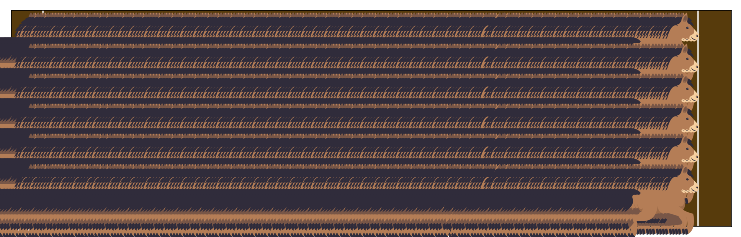

In [42]:
horse_anim = horse_animation(derby, CMAP)
horse_anim.save("derby_animation_horses.gif", writer="imagemagick", fps=24)
horse_anim